# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [5]:
bias = 500
X, y, coef = make_regression(n_samples=5000,
                             n_features=3,
                             bias=bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" +
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" +
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (np.float64(113.11), np.float64(865.44))
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

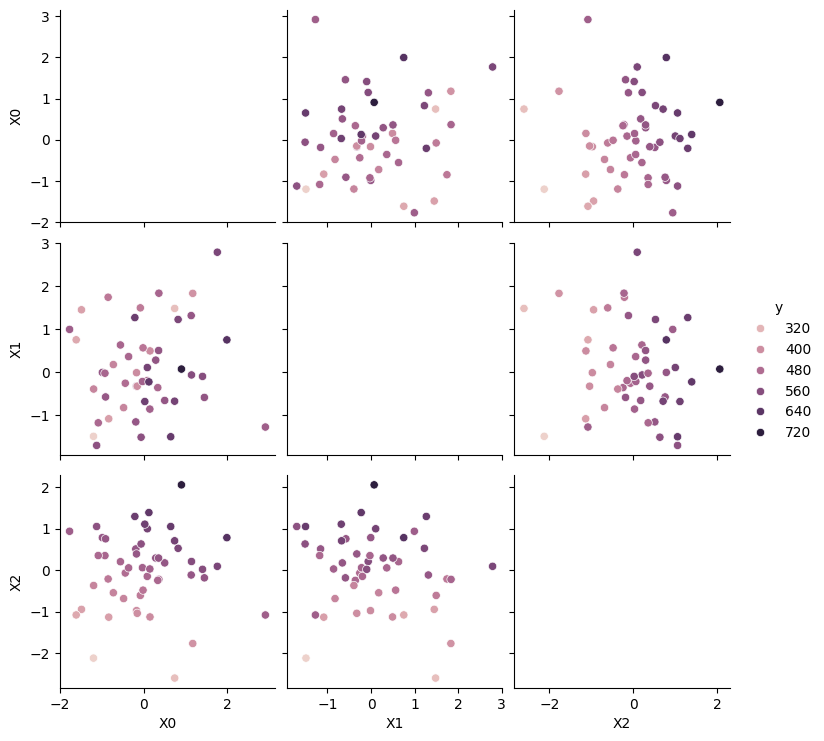

In [6]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [4]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))

    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [16]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [9]:
def descenso_gradiente(g: Callable[..., float],
                       dg: Callable[..., np.ndarray],
                       z_init: np.ndarray,
                       alpha: float,
                       num_iterations: int,
                       tol: float,
                       verbose: bool = False) -> np.ndarray:
    """
    Descenso de gradiente para minimizar g.
    Args:
        g: La función a optimizar.
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia.
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [11]:
from sklearn import preprocessing
from functools import partial

class RegresionLinealDG():

    def __init__(self,
        func_costo: Callable[..., float],
        func_costo_grad: Callable[..., np.ndarray],
        descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None
    ):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)

        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y,
                                    z_init=np.zeros(w_shape),
                                    **self.descenso_gradiente_hyperparams)

Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [12]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)

def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2/len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [13]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)

Entrenarla:

In [14]:
reg.fit(X,y)

Y obtener los w

In [17]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [18]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))

    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [19]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados

(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}`
    
    y reportar su comportamiento.


In [21]:
from sklearn.model_selection import ParameterGrid

hyperparametros = {"alpha": [0.001, 0.005, 0.01, 0.01],
                   "num_iterations": [1000, 3000, 4000, 5000],
                   "tol": [0.0001, 0.001, 0.01, 0.1]}
hyperparam_combs = ParameterGrid(hyperparametros)

comportamiento = pd.DataFrame(columns=["metodo", "alpha", "num_iter", "tol", "w0", "w1", "w2", "w3", "error_prediccion"])
for hyperparam_comb in hyperparam_combs:
    reg = RegresionLinealDG(mse, grad_mse, hyperparam_comb)
    reg.fit(X,y)
    err = error_prediccion(X, y, reg.w)
    comportamiento.loc[len(comportamiento)] = ["DescensoGradiente"] + list(hyperparam_comb.values()) + list(reg.w) + [err]
comportamiento

,metodo,alpha,num_iter,tol,w0,w1,w2,w3,error_prediccion
0,DescensoGradiente,0.001,1000,0.0001,432.516448,32.738181,1.897207,77.328265,4747.969090
1,DescensoGradiente,0.001,1000,0.0010,432.516448,32.738181,1.897207,77.328265,4747.969090
2,DescensoGradiente,0.001,1000,0.0100,432.516448,32.738181,1.897207,77.328265,4747.969090
3,DescensoGradiente,0.001,1000,0.1000,432.516448,32.738181,1.897207,77.328265,4747.969090
4,DescensoGradiente,0.001,3000,0.0001,498.789231,38.818228,1.503974,89.570414,2.594823
...,...,...,...,...,...,...,...,...,...
59,DescensoGradiente,0.010,4000,0.1000,498.474000,38.781860,1.510220,89.508816,3.515239
60,DescensoGradiente,0.010,5000,0.0001,499.972017,38.961170,1.477100,89.804989,1.002104
61,DescensoGradiente,0.010,5000,0.0010,499.868490,38.947261,1.480174,89.783687,1.023988
62,DescensoGradiente,0.010,5000,0.0100,499.531213,38.904996,1.488644,89.716010,1.252022


1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.


In [43]:
def mse_ridge(w: np.ndarray, l: float, X: np.ndarray, y: np.ndarray) -> float:
  return mse(w, X, y) + l*np.sum(w**2)

def grad_mse_ridge(w: np.ndarray, l: float, X: np.ndarray, y: np.ndarray) -> np.ndarray:
  return grad_mse(w, X, y) + 2*l*w

In [44]:
def mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, l: float) -> float:
  return mse(w, X, y) + l*np.sum(np.abs(w))

def grad_mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, l: float) -> np.ndarray:
  return grad_mse(w, X, y) + l*np.sign(w)

In [45]:
def mse_elastic_search(w: np.ndarray, X: np.ndarray, y: np.ndarray, l1: float, l2: float) -> float:
  return mse(w, X, y) + l1*np.sum(w**2) + l2*np.sum(np.abs(w))

def grad_mse_elastic_search(w: np.ndarray, X: np.ndarray, y: np.ndarray, l1: float, l2: float) -> np.ndarray:
  return grad_mse(w, X, y) + l1*2*w + l2*np.sign(w)

2. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.

In [34]:
from sklearn import preprocessing
from functools import partial



class RegresionLinealDGMB():
    def __init__(self,
        func_costo: Callable[..., float],
        func_costo_grad: Callable[..., np.ndarray],
        alpha: float,
        tol: float
    ):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.alpha = alpha
        self.tol = tol


    def fit(self,
        X: np.ndarray, y: np.ndarray,
        batch_size: Optional[float | int] = None,
        seed: Optional[int] = None
    ):
        # Agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        n_samples, n_features = X_train_ext.shape[0], X_train_ext.shape[1]

        if isinstance(batch_size, float):
            batch_size = int(batch_size * n_samples)

        # Mezclo el data set
        rng = np.random.default_rng(seed)
        indices = np.arange(n_samples)
        rng.shuffle(indices)
        X_train_ext = X_train_ext[indices]
        y_shuffled = y[indices]

        X_batches = np.array_split(X_train_ext, n_samples // batch_size)
        y_batches = np.array_split(y_shuffled, n_samples // batch_size)

        w_init = np.zeros(n_features)
        self.w = w_init

        for X_batch, y_batch in zip(X_batches, y_batches):
            cost_X_y = partial(self.func_costo, X=X_batch, y=y_batch)
            grad_cost_X_y = partial(self.func_costo_grad, X=X_batch, y=y_batch)

            w_new = self.w - (self.alpha * grad_cost_X_y(self.w))

            if abs(cost_X_y(self.w) - cost_X_y(w_new)) < self.tol:
                break

            self.w = w_new

In [70]:
alpha = 0.01
l1, l2 = 0.0001, 0.1
tol = 0.01
batch_size = 10

losses = {
    "mse": mse,
    "ridge": partial(mse_ridge, l=l1),
    "lasso": partial(mse_lasso, l=l2),
    "elastic_search": partial(mse_elastic_search, l1=l1, l2=l2)
}

grad_losses = {
    "mse": grad_mse,
    "ridge": partial(grad_mse_ridge, l=l1),
    "lasso": partial(grad_mse_lasso, l=l2),
    "elastic_search": partial(grad_mse_elastic_search, l1=l1, l2=l2)
}

regs = {
    "mse": RegresionLinealDGMB(losses["mse"], grad_losses["mse"], alpha, tol),
    "ridge": RegresionLinealDGMB(losses["ridge"], grad_losses["ridge"], alpha, tol),
    "lasso": RegresionLinealDGMB(losses["lasso"], grad_losses["lasso"], alpha, tol),
    "elastic_search": RegresionLinealDGMB(losses["elastic_search"], grad_losses["elastic_search"], alpha, tol)
}

resultados = pd.DataFrame(columns=["metodo", "loss", "w0", "w1", "w2", "w3", "error_prediccion"])

for reg_name, reg in regs.items():
    reg.fit(X, y, batch_size=batch_size)
    err = error_prediccion(X, y, reg.w)
    resultados.loc[len(resultados)] = ["DescensoGradienteMB"] + [reg_name] + list(reg.w) + [err]

resultados

,metodo,loss,w0,w1,w2,w3,error_prediccion
0,DescensoGradienteMB,mse,499.342184,38.904084,1.509262,89.612904,1.504128
1,DescensoGradienteMB,ridge,499.140485,38.842832,1.582199,89.800640,1.799409
2,DescensoGradienteMB,lasso,499.418768,38.775484,1.423126,89.609651,1.440554
3,DescensoGradienteMB,elastic_search,499.401113,38.868911,1.468179,89.661986,1.414953
